In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
 
from sklearn.metrics import classification_report, confusion_matrix
 
# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image
 
import cv2
 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# folders paths
train_path = "C:/Users/WeixiLi/Desktop/Broccoli/train"
test_path = "C:/Users/WeixiLi/Desktop/Broccoli/test"

In [3]:

# Data agumentation and pre-processing using tensorflow
gen = ImageDataGenerator(
                  rescale=1./255.,
                  horizontal_flip = True,
                  vertical_flip = True,
                  validation_split=0.2, # training: 80% data, validation: 20% data
                  brightness_range=[0.2,1.0]
                 )
 
train_generator = gen.flow_from_directory(
    #labels, # dataframe
    #directory = 
    train_path, # images data path / folder in which images are there
    #x_col = 'id',
    #y_col = 'breed',
    subset="training",
    color_mode="rgb",
    target_size = (240,320), # image height , image width
    class_mode="categorical",
    batch_size=64,
    shuffle=True,
    seed=42,
)
 
validation_generator = gen.flow_from_directory(
    #labels, # dataframe
    #directory = 
    train_path, # images data path / folder in which images are there
    #x_col = 'id',
    #y_col = 'breed',
    subset="validation",
    color_mode="rgb",
    target_size = (240,320), # image height , image width
    class_mode="categorical",
    batch_size=64,
    shuffle=True,
    seed=42,
)

Found 567 images belonging to 4 classes.
Found 141 images belonging to 4 classes.


In [4]:
# load the InceptionResNetV2 architecture with imagenet weights as base
base_model = tf.keras.applications.InceptionResNetV2(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(240,320,3)
                     )
 
base_model.trainable=False
# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
 
model = tf.keras.Sequential([
        base_model,  
        tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.7),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])

In [5]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# categorical cross entropy is taken since its used as a loss function for
# multi-class classification problems where there are two or more output labels.
# using Adam optimizer for better performance
# other optimizers such as sgd can also be used depending upon the model

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 6, 8, 1536)       54336736  
 onal)                                                           
                                                                 
 batch_normalization_203 (Ba  (None, 6, 8, 1536)       10752     
 tchNormalization)                                               
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

In [7]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.0001,
                                          restore_best_weights=True)
# early stopping call back

In [8]:
batch_size=64
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size
 
# fit model
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=40,
                    callbacks=[early])

Epoch 1/40
8/8 [==============================] - 201s 24s/step - loss: 1.3138 - accuracy: 0.4155 - val_loss: 1.0734 - val_accuracy: 0.4766
Epoch 2/40
8/8 [==============================] - 180s 23s/step - loss: 1.1485 - accuracy: 0.4095 - val_loss: 1.0574 - val_accuracy: 0.5078
Epoch 3/40
8/8 [==============================] - 180s 23s/step - loss: 1.1116 - accuracy: 0.4950 - val_loss: 1.0687 - val_accuracy: 0.5156
Epoch 4/40
8/8 [==============================] - 176s 22s/step - loss: 1.1228 - accuracy: 0.4433 - val_loss: 1.0243 - val_accuracy: 0.5156
Epoch 5/40
8/8 [==============================] - 176s 22s/step - loss: 1.0501 - accuracy: 0.5089 - val_loss: 0.9793 - val_accuracy: 0.5234
Epoch 6/40
8/8 [==============================] - 176s 22s/step - loss: 1.0238 - accuracy: 0.5149 - val_loss: 0.9916 - val_accuracy: 0.4844
Epoch 7/40
8/8 [==============================] - 176s 22s/step - loss: 0.9977 - accuracy: 0.5427 - val_loss: 0.9390 - val_accuracy: 0.5781
Epoch 8/40
8/8 [====

In [9]:
model.save("Model_transfer_learning.h5")

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: 0.8011928200721741\nValidation Accuracy: 0.7265625')

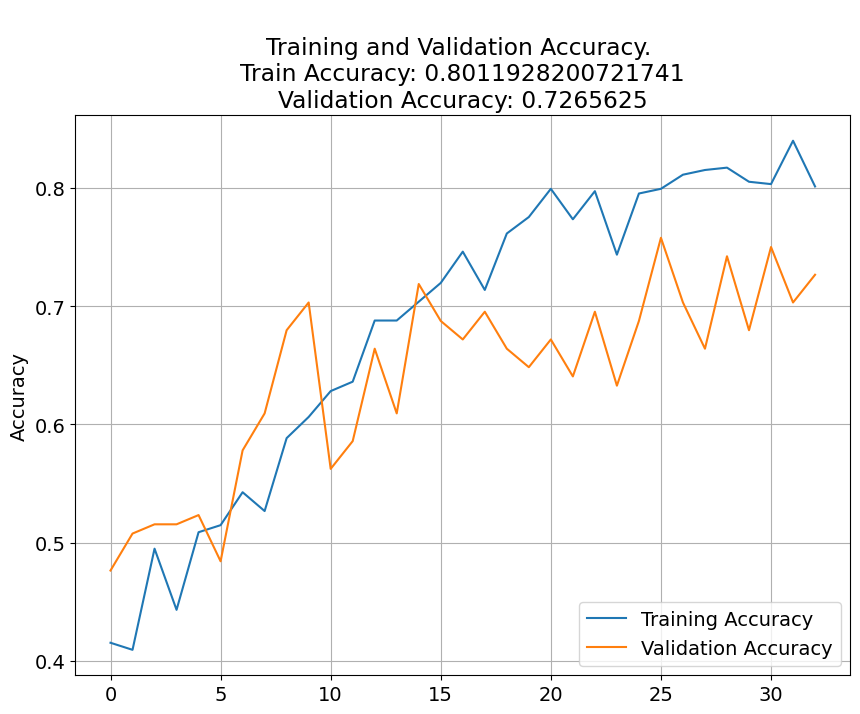

In [10]:
# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
 
# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

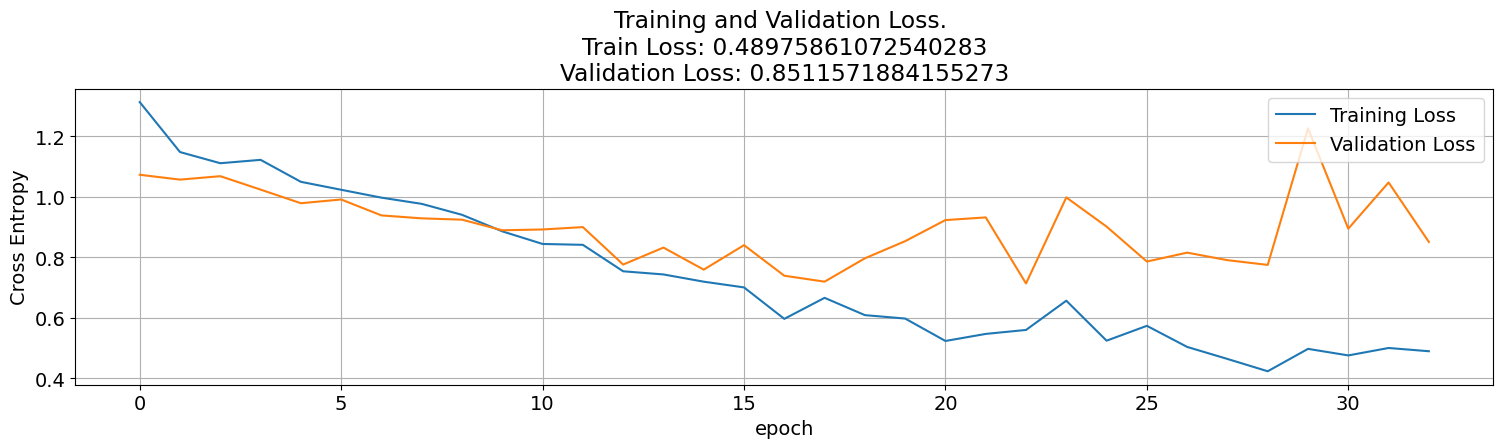

In [11]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [12]:
accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))
 
print("Loss: ",accuracy_score[0])

3/3 [==============================] - 39s 9s/step - loss: 0.7997 - accuracy: 0.6809
[0.7996882200241089, 0.6808510422706604]
Accuracy: 68.0851%
Loss:  0.7996882200241089


In [13]:
test_datagen = ImageDataGenerator(
                  rescale=1./255.,
                  #horizontal_flip = True,
                  #vertical_flip = True,
                  #validation_split=0.2, # training: 80% data, validation: 20% data
                  #brightness_range=[0.2,1.0]
                 )

test_generator = test_datagen.flow_from_directory(test_path,
                                                 shuffle=False,
                                                 batch_size=64,
                                                 target_size = (240, 320),
                                                 class_mode='categorical')

Found 380 images belonging to 4 classes.


In [14]:
predictions = model.predict(test_generator)

6/6 [==============================] - 108s 16s/step


In [15]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=64)

6/6 [==============================] - 101s 16s/step - loss: 0.9597 - accuracy: 0.6447


In [16]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.9596691131591797
Test Accuracy: 0.6447368264198303


In [17]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

In [18]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : 1
1 : 2
2 : 3
3 : 4


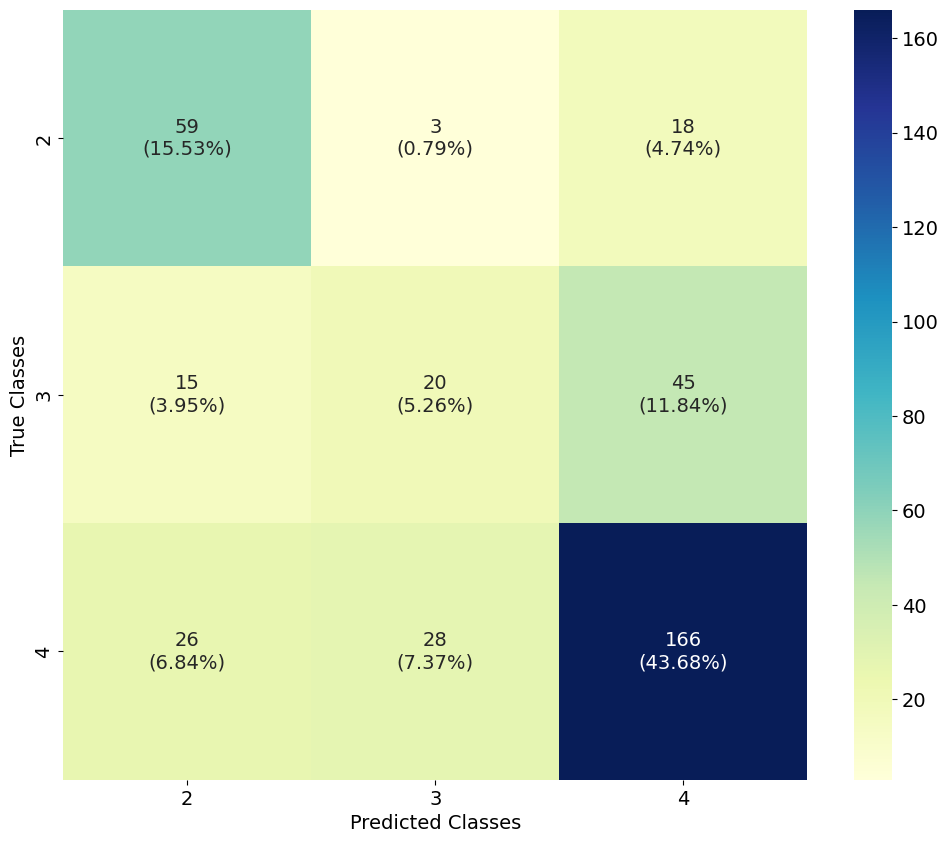

In [19]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(3, 3)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=[2,3,4], yticklabels=[2,3,4],
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()